In [17]:
from tianshou.env.pettingzoo_env import PettingZooEnv

from gym_multi_car_racing import multi_car_racing

import os
import gymnasium as gym
import numpy as np
import torch

import time

%reload_ext autoreload
%autoreload 2

In [13]:
from typing import Optional, Tuple

from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, ShmemVectorEnv, SubprocVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, PPOPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import offpolicy_trainer, onpolicy_trainer
from tianshou.utils.net.common import Net
from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.common import ActorCritic, Net
from tianshou.utils.net.continuous import ActorProb, Critic
from torch.distributions import Independent, Normal

import supersuit as ss

from torch import nn

In [14]:
# Number of agents
n_agents = 1

In [15]:
def _get_env():
    """This function is needed to provide callables for DummyVectorEnv."""
    env = multi_car_racing.env(n_agents=n_agents, use_random_direction=True,
                               render_mode="human", discrete_action_space=False)
    env = ss.frame_stack_v1(env, 4)
    return PettingZooEnv(env)

In [18]:
env = _get_env()
observation_space = (
    env.observation_space["observation"]
    if isinstance(env.observation_space, gym.spaces.Dict)
    else env.observation_space
)

In [15]:
env = multi_car_racing.env(n_agents=n_agents, use_random_direction=True,
                               render_mode="human", discrete_action_space=False)

In [16]:
import supersuit

#env = supersuit.pettingzoo_env_to_vec_env_v1(env)


In [19]:
env.observation_space

<bound method shared_wrapper_aec.observation_space of <supersuit.generic_wrappers.utils.shared_wrapper_util.shared_wrapper_aec object at 0x7fd6046200d0>>

In [6]:
def dist(*logits):
        return Independent(Normal(*logits), 1)

def _get_agents(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = _get_env()
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gym.spaces.Dict)
        else env.observation_space
    )
    if agent_learn is None:
        hidden_sizes = [32,32]
        # model
        net = Net(observation_space.shape, hidden_sizes=hidden_sizes, device="cuda")
        actor = ActorProb(net, env.action_space.shape, device="cuda").to("cuda")
        critic = Critic(Net(observation_space.shape, hidden_sizes=hidden_sizes, device="cuda"), device="cuda").to("cuda")
        actor_critic = ActorCritic(actor, critic)

        optim = torch.optim.Adam(actor_critic.parameters(), lr=1e-3)

        agent_learn = PPOPolicy(
                    actor,
                    critic,
                    optim,
                    dist,
                    discount_factor=0.99,
                    action_space=env.action_space,
                    action_bound_method="clip",)

    if agent_opponent is None:
        agent_opponent = RandomPolicy()

    #agents = [agent_opponent, agent_learn]
    agents = [agent_learn]
    policy = MultiAgentPolicyManager(agents, env)
    return policy, optim, env.agents

In [7]:
# ======== Step 1: Environment setup =========
train_envs = DummyVectorEnv([_get_env for _ in range(1)])   # DummyVectorEnv
test_envs = DummyVectorEnv([_get_env for _ in range(1)])

# seed
seed = 42
np.random.seed(seed)
#torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)

[None]

In [8]:
# ======== Step 2: Agent setup =========
policy, optim, agents = _get_agents(agent_learn=None)

load_policy = False
# Load saved policy
if load_policy:
    policy.policies['car_0'].load_state_dict(torch.load(os.path.join("log", "rps", "dqn", "policy.pth")))

In [9]:
# ======== Step 3: Collector setup =========

buffer = VectorReplayBuffer(20_000, len(train_envs))

train_collector = Collector(
    policy,
    train_envs,
    buffer,
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)
# policy.set_eps(1)

In [10]:
train_collector.collect(n_step=64*10)  # batch size * training_num

{'n/ep': 1,
 'n/st': 640,
 'rews': array([[162.68888889]]),
 'lens': array([558]),
 'idxs': array([0]),
 'rew': 162.68888888889003,
 'len': 558.0,
 'rew_std': 0.0,
 'len_std': 0.0}

In [11]:
# ======== Step 4: Callback functions setup =========

agent = 0  # 1 if there are two agents

def save_best_fn(policy):
    model_save_path = os.path.join("log", "ppo", "policy.pth")
    os.makedirs(os.path.join("log", "ppo"), exist_ok=True)
    torch.save(policy.policies[agents[agent]].state_dict(), model_save_path)

def stop_fn(mean_rewards):
    return mean_rewards >= 800

def reward_metric(rews):
    return rews[:, agent]

In [ ]:
import numpy as np

# Make a function that maps the range (-1, 1) to (0, 1)
def scale_reward(rew):
    return (rew + 1) / 2

Log results to Weights and Biases

In [12]:
from tianshou.utils import WandbLogger
from torch.utils.tensorboard import SummaryWriter

log_path = os.path.join("log", "dqn")

logger = WandbLogger(save_interval=1, project='multi_car_racing', name='ppo_one_car')
writer = SummaryWriter()
logger.load(writer)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: juanzapata. Use `wandb login --relogin` to force relogin
/home/juan/masters_thesis/.venv/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:70: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [13]:
# ======== Step 5: Run the trainer =========
result = onpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=50,
    step_per_epoch=1000,
    repeat_per_collect=4,
    episode_per_test=10,
    episode_per_collect=4,
    batch_size=64,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    test_in_train=True,
    reward_metric=reward_metric,
    logger=logger,
    verbose=True
)

print(f"\n==========Result==========\n{result}")
print("\n(the trained policy can be accessed via policy.policies[agents[1]])")

Epoch #1: 4958it [02:24, 34.38it/s, car_0/loss=102.618, car_0/loss/clip=0.327, car_0/loss/ent=4.273, car_0/loss/vf=204.667, env_step=4958, len=1260, n/ep=4, n/st=4958, rew=216.90]


Epoch #1: test_reward: 489.934933 ± 371.078146, best_reward: 489.934933 ± 371.078146 in #1


Epoch #2: 7457it [03:30, 35.45it/s]               

: 

: 

_______

0.69411767


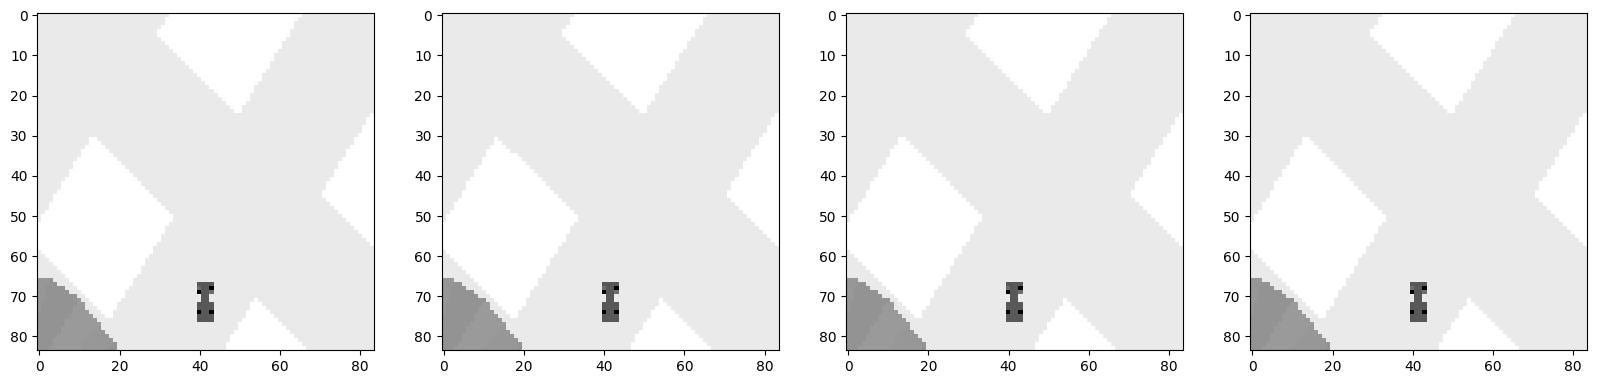

In [50]:
import numpy as np
import matplotlib.pyplot as plt

obs_next = np.load("obs_next.npy", allow_pickle=True)

print(obs_next[0]['obs'].max())

plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(obs_next[0]['obs'][:,:,i], cmap='gray')

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
from gym_multi_car_racing import multi_car_racing
import supersuit as ss
from tianshou.env.pettingzoo_env import PettingZooEnv

n_agents = 1
frame_stack = 4
# Step 1: Load the PettingZoo environment
env = multi_car_racing.env(n_agents=n_agents, render_mode="human", discrete_action_space=False)
#env = ss.frame_stack_v1(env, frame_stack)
# Step 2: Wrap the environment for Tianshou interfacing
env = PettingZooEnv(env)

In [6]:
env.observation_space

Box(0, 1, (96, 96, 3), uint8)

In [2]:
env = multi_car_racing.parallel_env(n_agents=n_agents, render_mode="human", discrete_action_space=False)

In [7]:
env.reset()
for i in range(200):
    env.step(env.action_space.sample())

________

In [1]:
from atari_network import DQN, scale_obs, layer_init
import torch

In [11]:
net = DQN(c=3, h=96, w=96, layer_init=layer_init, action_shape=(3,), device="cuda",
          output_dim=512, features_only=True).to("cuda")

In [12]:
input_size = [(3, 96, 96)]
dtype = torch.cuda.FloatTensor

[torch.rand(1, *in_size).type(dtype) for in_size in input_size][0].shape

torch.Size([1, 3, 96, 96])

In [7]:
net(torch.zeros(1, 96, 96))

OBS:  torch.Size([1, 96, 96])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 4096x512)

In [115]:
np.prod(net(torch.zeros(1, 96, 96)).shape[1:])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 4096x512)

__________________

### Test model

In [ ]:
env = gym.make("MultiCarRacing-v0", num_agents=1, direction='CCW',
        use_random_direction=True, backwards_flag=True, h_ratio=0.25,
        use_ego_color=False)
#env = DummyVecEnv([lambda: env])

In [ ]:
evaluate_policy(model, env, n_eval_episodes=1, render=True)

/home/developer/.local/share/virtualenvs/workspace-LQiMqFvY/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/developer/.local/share/virtualenvs/workspace-LQiMqFvY/lib/python3.8/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:208: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Track generation: 1013..1278 -> 265-tiles track
Track generation: 1027..1288 -> 261-tiles track


(-1.515151523053646, 0.0)

In [ ]:
# Alternative way of testing the model

episodes = 1

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0

    avg_time_per_step = []

    t0 = time.time()
    while not done:
        env.render()
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action) 
        score += reward if reward != -100 else 0

        # Time per step
        t1 = time.time()
        delta = t1 - t0
        t0 = t1
        avg_time_per_step.append(delta)
        print(f"Time per step: {delta:.5f}s", end="\r")

    print(f"Episode: {episode} Score: {score}")
    print(f"Average time per step: {np.mean(avg_time_per_step):.5f}s")

env.close()

Track generation: 1196..1499 -> 303-tiles track
Episode: 1 Score: [-33.77483444]
Average time per step: 0.05716s


## Modifying the environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
environment_name = "CarRacing-v2"
env = gym.make(environment_name, render_mode="human")
env = DummyVecEnv([lambda: env])

In [ ]:
env.action_space.sample()

array([0.6228343 , 0.10581603, 0.9364147 ], dtype=float32)

In [ ]:
image = np.load("image.npy")



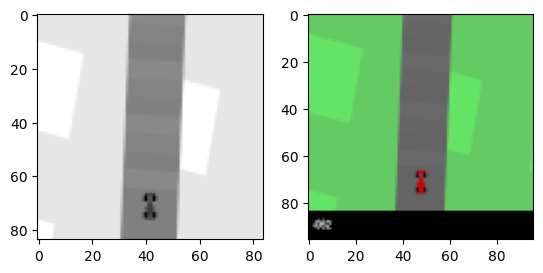

In [ ]:
plt.imshow(image)